In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print(device.type)

# ---

torch.manual_seed(42)
np.random.seed(42)

cuda


In [3]:
t_steps = 200
num_demos = 100
num_val = 20
dx, dy = 1, 1
x = torch.linspace(0, 1, t_steps).repeat(int(num_demos/2), 1)

noise = torch.clamp(torch.randn(x.shape)*1e-4**0.5, min=0)
y0 = torch.unsqueeze(torch.sin(x*torch.pi) + noise, 2)

y1 = 1-y0

x = torch.unsqueeze(x.repeat(2,1), 2)
y = torch.cat((y0, y1), 0)
print("X:", x.shape, "Y:", y.shape)

path = "."

#######################################

vx = torch.linspace(0, 1, t_steps).repeat(int(num_val/2), 1)
vnoise = torch.clamp(torch.randn(vx.shape)*1e-4**0.5, min=0)
vy0 = torch.unsqueeze(torch.sin(vx*torch.pi) + vnoise, 2)
vy1 = 1-vy0

vx = torch.unsqueeze(vx.repeat(2,1), 2)
vy = torch.cat((vy0, vy1), 0)

X: torch.Size([100, 200, 1]) Y: torch.Size([100, 200, 1])


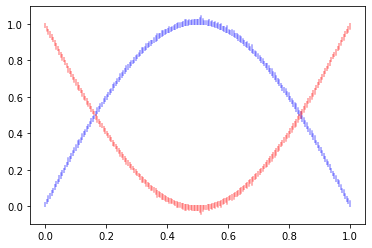

In [4]:
plt.plot(x[:50, :, 0], y[:50, :, 0], 'b', alpha=0.3)
plt.plot(x[51:, :, 0], y[51:, :, 0], 'r', alpha=0.3)
plt.show()

In [5]:
n_max = 6

def sample_training_demonstration():    
    rand_traj_ind = np.random.randint(0, num_demos)
    n = np.random.randint(1, n_max+1)

    rand_traj = y[rand_traj_ind, :, :]

    observation_indices = np.random.choice(np.arange(t_steps), n+1, replace=False) # n+1: +1 is for sampling the target
    
    observations = torch.cat((rand_traj[observation_indices[:-1], :], 
                              x[rand_traj_ind, observation_indices[:-1], :]), 1)
    targetX = torch.unsqueeze(torch.Tensor(x[rand_traj_ind, observation_indices[-1], :]), 0)
    targetY = torch.unsqueeze(torch.Tensor(rand_traj[observation_indices[-1], :]), 0)
    
    type_id = 0 if rand_traj_ind<num_demos/2 else 1
    
    if device.type == 'cuda':
        return observations.float().cuda(), type_id, targetX.float().cuda(), targetY.float().cuda()
    else:
        return observations.float(), type_id, targetX.float(), targetY.float()


def get_validation_demonstration(ind):
    type_id = 0 if ind<num_val/2 else 1
    x = vx[ind, :, :]
    y = vy[ind, :, :]
    
    if device.type == 'cuda':
        return x.float().cuda(), y.float().cuda(), type_id
    else:
        return x, y, type_id

In [6]:
class BCNP(nn.Module):
    def __init__(self, in_shape):
        super(BCNP, self).__init__()
        
        dx, dy = in_shape[0], in_shape[1]
        
        dz = 128
        dzt = dz+dx
        
        self.encoder = nn.Sequential(
            nn.Linear(dx+dy, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, dz)
        )
        
        self.f0 = nn.Sequential(
            nn.Linear(dzt, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, dy*2)
        )

        self.f1 = nn.Sequential(
            nn.Linear(dzt, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, dy*2)
        )
        

    def forward(self, observations, type_id, target):
        z_out = self.encoder(observations)
        z = torch.mean(z_out, dim=0)

        zs = z.repeat(target.shape[0], 1).to(device)  # repeating the same z for each target
        z_target = torch.cat((zs, target), 1)
        
        if type_id == 0:
            return self.f0(z_target)
        else:
            return self.f1(z_target)


def log_prob_loss(ty, ty_pred):
    m, s = ty_pred.chunk(2, dim = -1)
    s = F.softplus(s)
    dist = D.Independent(D.Normal(loc=m, scale=s), 1)
    return -torch.mean(dist.log_prob(ty))


def validate():
    verr=torch.zeros(num_val)
    with torch.no_grad():
        for i in range(num_val):
            val_x, val_y, type_id = get_validation_demonstration(i)

            cond_step = 0
            observation = torch.Tensor([val_y[cond_step, :], val_x[cond_step, :]]).view(1, dx+dy).float().cuda()
            
            pred_traj = torch.zeros_like(val_y)
            pred_traj[cond_step, :] = val_y[cond_step, :]

            for t in range(1, t_steps):
                pred = model(observation, type_id, torch.unsqueeze(val_x[t], 0))
                pred_traj[t, :], _ = pred.chunk(2, dim = -1)  # pred[0]: mean, pred[1]: std

            verr[i] = torch.sum((val_y - pred_traj) ** 2)
    return torch.mean(verr)

In [7]:
model = BCNP((1, 1))
model.to(device)

optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters(), betas=(0.9, 0.999), amsgrad=True)

val_after_iter = 2500
iters = 10000000

losses = []
min_verr = 1e6

for i in range(iters):
    obss, type_id, tx, ty = sample_training_demonstration()
    
    optimizer.zero_grad()
    ty_preds = model(obss, type_id, tx)
    loss = log_prob_loss(ty, ty_preds)
    
    if type_id == 0:
        model.f0.requires_grad = True
        model.f1.requires_grad = False
    else:
        model.f0.requires_grad = False
        model.f1.requires_grad = True
    
    loss.backward()
    optimizer.step()
    
    if (i)%val_after_iter == 0:
        verr = validate()
        print(f"{i}: {verr}", end="\r")
        losses.append(verr)

        if verr < min_verr:
            min_verr = verr
            torch.save(model.state_dict(), f'{path}/best_model_v0.pt')

KeyboardInterrupt: 

In [ ]:
plt.plot(range(len(losses[:50])), losses[:50])